In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu115.html

In [ ]:
!pip install git+https://github.com/SberProcessMining/Sber_Process_Mining.git
!pip install pm4py
!pip install -U matplotlib

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
!pip uninstall tornado
!pip install tornado==4.5.3

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator,FullBatchNodeGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline
import pandas as pd
import sys
sys.path.append('/content/drive/MyDrive/Drill planner/Code')
from Drill_planner import DrillPlaner, nx_graph, GraphMiner, DrillGraphMiner
import networkx as nx
import numpy as np
from torch_geometric.nn.conv import MessagePassing
import torch.nn as nn

In [ ]:
import torch_geometric as pyg
import torch
import numpy as np
import copy
from tqdm import trange
from torch_geometric.data import DataLoader
from torch_geometric.utils import negative_sampling

# Dataset

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/Drill planner/Data/Dataset2.xlsx')

In [ ]:
from sklearn.preprocessing import LabelEncoder
def prepare_features(dataset):
  le = LabelEncoder()
  dataset['Section'] = le.fit_transform(dataset['Section'])
  dataset['Phase'] = le.fit_transform(dataset['Phase'])
  dataset = dataset[['Section','Phase','Time, h (in grains)','Operation code']]
  return dataset

In [ ]:
class GraphMiner():
  def __init__(self, name, predecessor, assoc_time, parent_time):
    self.parent = predecessor
    self.name = name
    self.time = assoc_time
    self.parent_time = parent_time


class DrillGraphMiner():
  def __init__(self, data, time_name, code_name):
    graph_codes = []
    codes = data[code_name].to_numpy()  # can pass codes and times instead of raw data, suitably changing the code
    times = np.round(data[time_name].to_numpy(), 2)
    events = ['startevent'] + list(set(codes)) + ['endevent']

    for i in range(len(codes[1:])):
      graph_codes.append(GraphMiner(codes[i + 1], codes[i], times[i + 1], times[i]))
    graph_codes.append(GraphMiner('endevent', codes[-1], times[-1] + 1e-10, times[-1]))
    graph_codes.insert(0, GraphMiner(codes[0], 'startevent', times[0], times[0] - 1e-10))
    gr = np.zeros((len(events), len(events)))

    for bullet in graph_codes:  # digraph from row to column
      gr[events.index(bullet.parent), events.index(bullet.name)] = bullet.time
    self.graph_matrix = gr
    self.nodes = events


    self.dataset = prepare_features(data)

    self.node_features = dataset.to_numpy()
    self.dataset['source'] = dataset['Operation code']
    self.dataset['target'] = operation_lag(dataset,['Operation code'],1)

  @staticmethod
  def prepare_features(dataset):
    le = LabelEncoder()
    dataset['Section'] = le.fit_transform(dataset['Section'])
    dataset['Phase'] = le.fit_transform(dataset['Phase'])
    dataset = dataset[['Section', 'Phase', 'Time, h (in grains)', 'Operation code']]
    return dataset

  @staticmethod
  def operation_lag(data, code_column, lag,next_operation=False):
    df = np.zeros_like(data[code_column].values)
    df[lag:] = data[code_column].values[:-lag]
    if next_operation:
      df[:-lag] = data[code_column].values[lag:]
    return df



  def to_dfg(self):
    self.dfg = nx.from_numpy_matrix(self.graph_matrix, create_using=nx.DiGraph())
    miner_nodes = {a: self.nodes[a] for a in self.dfg.nodes}
    self.dfg = nx.relabel_nodes(self.dfg, miner_nodes)
    self.graph_edges = list(map(lambda x: (str(x[0]), str(x[1])), list(self.dfg.edges())))
    self.graph_nodes = list(map(str, self.dfg.nodes()))
    return self.dfg

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [ ]:
#dataset = prepare_features(dataset)
dataset['Operation code'] = dataset['Operation code'].astype(int)
burek = dataset[dataset['Phase'] == 'БУРЭК']
graph_planner = DrillGraphMiner(dataset, 'Time, h (in grains)', 'Operation code')
DFG =graph_planner.to_dfg()

In [ ]:
formatted_features = prepare_features(dataset)

In [ ]:
dict_features = formatted_features.to_dict()

In [ ]:
nx.set_node_attributes(DFG,dict_features)

In [ ]:
graph_planner.dataset['weight'] = formatted_features['Time, h (in grains)']

In [ ]:
sg_graph = sg.StellarGraph({"feautres": formatted_features}, edges = graph_planner.dataset[['source','target','weight']])
#print(cora_no_subject.info())

In [ ]:
# edge_index = pyg.utils.from_networkx(sg_graph).edge_index
# edge_index

# data = pyg.data.Data(edge_index=edge_index)
# nx_data = pyg.utils.to_networkx(data, to_undirected=True)
# sg_graph = sg.StellarGraph(nx_data)
# sg_graph.node_features = G.node_features

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(sg_graph)


G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.2, method="global", keep_connected=True
)

** Sampled 777 positive and 777 negative edges. **


In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(sg_graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.2, method="global", keep_connected=True
)

** Sampled 777 positive and 777 negative edges. **


# Creating the GCN link model

In [ ]:
epoch = 50

In [ ]:
#G_train.node_features = G.node_features()

In [ ]:
# dir(G_train)
# G_train.node_feature_sizes()
# G_train.unique_node_type()
# G_train.node_features()
# G_train.node_features = G.node_features
# G_train.node_feature_sizes = G.node_feature_sizes
# G_train.unique_node_type = G.unique_node_type

In [ ]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [ ]:
# G_test.node_features = G.node_features
# G_test.node_feature_sizes = G.node_feature_sizes
# G_test.unique_node_type = G.unique_node_type

In [ ]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
logits = link_classification(
    output_dim=1, output_act="linear", edge_embedding_method="ip"
)(x_out)

prediction = keras.layers.Activation(keras.activations.sigmoid)(logits)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [ ]:
#prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
#prediction

In [ ]:
#prediction = keras.layers.Reshape((-1,))(prediction)

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [ ]:
epochs = 10
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/10
125/125 - 5s - loss: 0.5136 - acc: 0.7661 - val_loss: 0.7631 - val_acc: 0.5335 - 5s/epoch - 36ms/step
Epoch 2/10


KeyboardInterrupt: ignored

In [ ]:
sg.utils.plot_history(history)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 137ms/step - loss: 7.6246 - acc: 0.0000e+00

Train Set Metrics of the trained model:
	loss: 7.6246
	acc: 0.0000

Test Set Metrics of the trained model:
	loss: 7.6246
	acc: 0.0000


# SAGE link prediction

In [ ]:
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification

In [ ]:
num_samples = [20, 5]
batch_size = 10

In [ ]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)

In [ ]:
layer_sizes = [64, 64]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.2
)

In [ ]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

In [ ]:
logits = link_classification(
    output_dim=1, output_act="linear", edge_embedding_method="ip"
)(x_out)

prediction = keras.layers.Activation(keras.activations.sigmoid)(logits)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-2),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

In [ ]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))



print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

156/156 [==============================] - 2s 15ms/step - loss: 0.8010 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 0.8037
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 0.8010
	binary_accuracy: 0.5000


In [ ]:
epochs = 10
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False,
)

Epoch 1/10
156/156 - 198s - loss: 0.5442 - binary_accuracy: 0.7246 - val_loss: 0.7852 - val_binary_accuracy: 0.5071 - 198s/epoch - 1s/step
Epoch 2/10
156/156 - 5s - loss: 0.5342 - binary_accuracy: 0.7239 - val_loss: 0.7801 - val_binary_accuracy: 0.5373 - 5s/epoch - 32ms/step
Epoch 3/10
156/156 - 5s - loss: 0.5260 - binary_accuracy: 0.7381 - val_loss: 0.7759 - val_binary_accuracy: 0.5380 - 5s/epoch - 30ms/step
Epoch 4/10
156/156 - 5s - loss: 0.5255 - binary_accuracy: 0.7375 - val_loss: 0.7788 - val_binary_accuracy: 0.5373 - 5s/epoch - 30ms/step
Epoch 5/10
156/156 - 5s - loss: 0.5237 - binary_accuracy: 0.7568 - val_loss: 0.7821 - val_binary_accuracy: 0.5373 - 5s/epoch - 31ms/step
Epoch 6/10
156/156 - 4s - loss: 0.5245 - binary_accuracy: 0.7394 - val_loss: 0.7771 - val_binary_accuracy: 0.5335 - 4s/epoch - 28ms/step
Epoch 7/10
156/156 - 5s - loss: 0.5211 - binary_accuracy: 0.7561 - val_loss: 0.7790 - val_binary_accuracy: 0.5180 - 5s/epoch - 32ms/step
Epoch 8/10
156/156 - 5s - loss: 0.5259 

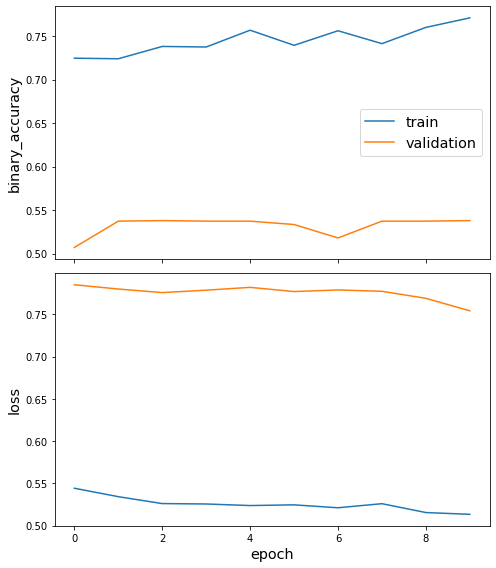

In [ ]:
sg.utils.plot_history(history)

In [ ]:
train_metrics = model.evaluate(train_flow)

test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))


print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

156/156 [==============================] - 2s 16ms/step - loss: 0.7543 - binary_accuracy: 0.5380

Train Set Metrics of the trained model:
	loss: 0.7591
	binary_accuracy: 0.5302

Test Set Metrics of the trained model:
	loss: 0.7543
	binary_accuracy: 0.5380


# Metrics link prediction

https://www.geeksforgeeks.org/link-prediction-predict-edges-in-a-network-using-networkx/

In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/Drill planner/Data/Dataset2.xlsx')
dataset['Operation code'] = dataset['Operation code'].astype(int)
burek = dataset[dataset['Phase'] == 'БУРЭК']
graph_planner = DrillGraphMiner(burek, 'Time, h (in grains)', 'Type of work')
DFG =graph_planner.to_dfg()

## Resource allocation index

In [ ]:
undirected = nx.to_undirected(DFG)

In [ ]:
rai = (list(nx.resource_allocation_index(undirected)))

In [ ]:
rai.sort(key=lambda a: a[2],reverse=True)
print(rai)

[('Прямая проработка', 'Проработка перед наращиванием', 0.7825396825396825), ('Промывка с расхаживанием и вращением БИ (не более 1 свечи)', 'Сборка КНБК с ВЗД с ТС', 0.6587301587301588), ('Подъем КНБК в обсаженном стволе', 'Сборка КНБК с ВЗД с ТС', 0.6428571428571428), ('Подъем КНБК в открытом стволе', 'Сборка КНБК с ВЗД с ТС', 0.6428571428571428), ('Спуск КНБК в открытом стволе', 'Бурение ВЗД с вращением БК', 0.6406926406926408), ('Подъем КНБК в открытом стволе', 'Бурение ВЗД с вращением БК', 0.6359307359307358), ('Опрессовка ВЗД', 'Спуск КНБК в обсаженном стволе', 0.625), ('Продувка гидравлических линий', 'Сборка КНБК с ВЗД с ТС', 0.6111111111111112), ('Прямая проработка', 'Выход на режим', 0.5777777777777777), ('Подъем КНБК в открытом стволе', 'Выход на режим', 0.5142857142857142), ('Ориентирование отклонителя', 'Прокачка пачки', 0.5051948051948052), ('Подъем КНБК в открытом стволе', 'Опрессовка оборудования БРД', 0.5), ('Монтаж оборудования БРД', 'Выход на режим', 0.5), ('Спуск КНБ

# Jaccard index

In [ ]:
jacc_coef = (list(nx.jaccard_coefficient(undirected)))
jacc_coef.sort(key=lambda a: a[2],reverse=True)
print(jacc_coef)

[('Бурение с вращением без ВЗД', 'Спуск КНБК в обсаженном стволе', 0.5), ('Подъем КНБК в обсаженном стволе', 'Спуск КНБК в открытом стволе', 0.5), ('Бурение с контролем давления', 'Ориентирование отклонителя', 0.5), ('Монтаж оборудования БРД', 'Обратная проработка', 0.5), ('Наращивание во время бурения трубкой (с мостков)', 'Промывка без расхаживания и вращения БИ', 0.5), ('Обратная проработка', 'Разборка КНБК с ВЗД без ТС', 0.5), ('Промывка без расхаживания с вращением БИ', 'Снятие замеров с ТС', 0.5), ('Снятие замеров с ТС перед наращиванием', 'Бурение с контролем давления', 0.45454545454545453), ('Бурение с вращением без ВЗД', 'Снятие замеров с ТС перед наращиванием', 0.4444444444444444), ('Бурение с вращением без ВЗД', 'Бурение с контролем давления', 0.4444444444444444), ('Ориентирование отклонителя', 'Прокачка пачки', 0.4444444444444444), ('Наращивание во время бурения свечой', 'Бурение ВЗД без вращения БК', 0.42857142857142855), ('Наращивание во время бурения', 'Прокачка пачки', 